In [10]:
from sklearn import linear_model
import csv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [11]:
File = open('HVAC_code.csv','r')

In [12]:
reader = csv.reader(File, delimiter = ',')
code = list(reader)

In [13]:
code = np.array(code)

In [14]:
data = np.genfromtxt('HVAC.csv',delimiter=',',skip_header=1)

In [15]:
Predictor = data[:, 0:69]
print(Predictor.shape)

(5215L, 69L)


In [16]:
Target = data[:, 69:75]
print(Target.shape)

(5215L, 6L)


In [17]:
all_predictor = list(range(69))
len(all_predictor)

69

In [18]:
numeric_index = [0, 1, 19, 20, 21, 22, 23, 24, 25, 36, 45, 46, 47, 48, 49, 50, 51, 52, 67, 68]

In [19]:
bi_no_index = [item for item in all_predictor if item not in numeric_index]

In [20]:
print(len(numeric_index))
print(len(bi_no_index))
len(numeric_index) + len(bi_no_index) == len(all_predictor)

20
49


True

The missing data is imputed based on different data type

In [21]:
imp_bi = Imputer(missing_values='NaN', strategy='most_frequent', axis = 0)
imp_bi.fit(Predictor[:,bi_no_index])
Predictor[:,bi_no_index] = imp_bi.transform(Predictor[:,bi_no_index])

In [22]:
imp_num = Imputer(missing_values='NaN', strategy='median', axis = 0)
imp_num.fit(Predictor[:,numeric_index])
Predictor[:,numeric_index] = imp_num.transform(Predictor[:,numeric_index])

In [23]:
Predictor.shape

(5215L, 69L)

In [24]:
imp_tar = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
imp_tar.fit(Target)
Target = imp_tar.transform(Target)

In [25]:
Target.shape

(5215L, 6L)

In [26]:
trainPredictor = Predictor[0:len(Predictor)//2]
testPredictor = Predictor[len(Predictor)//2: len(Predictor)]
trainTarget = Target[0:len(Target)//2]
testTarget = Target[len(Target)//2:len(Target)]
print(len(trainPredictor) + len(testPredictor) == len(Predictor))
print(len(trainTarget) + len(testTarget) == len(Target))
print(len(trainPredictor) == len(trainTarget))
print(len(testPredictor) == len(testTarget))
print(trainPredictor.shape)
print(trainTarget.shape)

True
True
True
True
(2607L, 69L)
(2607L, 6L)


In [27]:
#the function returns the lasso coefficients generated by the fit
def lasso_fit(alpha, predictor, Target):
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(predictor,Target)
    coefficient = clf.coef_
    return coefficient

In [28]:
# the function returns the y matrix of test dataset
def lasso_results(alpha_input, train_X, train_y, test_X, test_y):
    clf = linear_model.Lasso(alpha=alpha_input)
    clf.fit(train_X,train_y)
    #print(clf.coef_.shape)
    #print(clf.intercept_)
    oneMatrix = np.ones((len(test_X),1))
    DesignMatrix = np.concatenate((test_X, oneMatrix),axis = 1)
    #print(DesignMatrix.shape)
    coefficients = np.concatenate((clf.coef_ , [clf.intercept_]), axis = 0)
    #print(coefficients.shape
    testResults = np.dot(DesignMatrix, coefficients)
    return testResults

In [29]:
# the function returns the evaluator of the lasso fit (r_square, mse)
def lasso_test(alpha_input, train_X, train_y, test_X, test_y, testWeight):
    r_square = []
    mse = []
    for a in alpha_input:
        testResults = lasso_results(a, train_X, train_y, test_X, test_y)
        r_square.append(r2_score(test_y, testResults, sample_weight = testWeight))
        mse.append(mean_squared_error(test_y, testResults, sample_weight =testWeight))
    index = mse.index(min(mse))
    print(r_square[index])
    print(mse[index])
    print(alpha_input[index])
    evaluator = np.stack((r_square, mse), axis = 1)
    return evaluator

In [34]:
#find best fit using LassoCV
def lasso_cros(alpha_input, train_X, train_Y, test_X, test_Y):
    clf2 = LassoCV(alphas = alpha_range, cv = 5)
    clf2.fit(train_X, train_Y)
    print(clf2.score(train_X, train_Y))
    print(clf2.alpha_)
    #print(alpha_range.shape)
    print(clf2.mse_path_.shape)
    print(clf2.intercept_)
    #print(clf2.alphas_)
    #print(clf2.mse_path_.mean(axis=-1))
    plt.figure(figsize=(15,10)) 
    plt.plot(np.log10(clf2.alphas_), clf2.mse_path_[:], '--')
    plt.plot(np.log10(clf2.alphas_), clf2.mse_path_.mean(axis=-1), 'k-')
    plt.show()
    return {'alpha':clf2.alpha_, 'r_square':clf2.score(train_X, train_Y), 'intercept':clf2.intercept_}

In [31]:
#the function find the number of feathers selected and returns the 
#index of the features selected
def find_features(coeff):
    index = []
    count = 0
    for i in range(len(coeff)):
        if coeff[i] != 0:
            index.append(i)
            count += 1
    return {'index':index, 'count': count}

In [37]:
#this function give the number of features selected under each alpha
def num_feature(alpha_input, train_X, train_y):
    num_feature = []
    for alpha_input in alpha_input:
        clf = linear_model.Lasso(alpha=alpha_input)
        clf.fit(train_X,train_y)
        num = find_features(clf.coef_)["count"]
        num_feature.append(num)
    return num_feature

Use the self-written function to assess the fit

Define the range of alpha

In [43]:
alpha_range = np.logspace(-5, 5, num = 1000, base = 10)

Returns the evaluators by self-written functions (we first fit HT+CL)

In [35]:
evaluator = lasso_test(alpha_range, trainPredictor, trainTarget[:,4], testPredictor, testTarget[:,4], testTarget[:,5])

0.226062933709
2323.11380487
0.00849753435909


In [38]:
#and number of features selected from given alpha range
num_feature = num_feature(alpha_range, trainPredictor, trainTarget[:,4])

Plot a diagram of the evaluators change with alphas

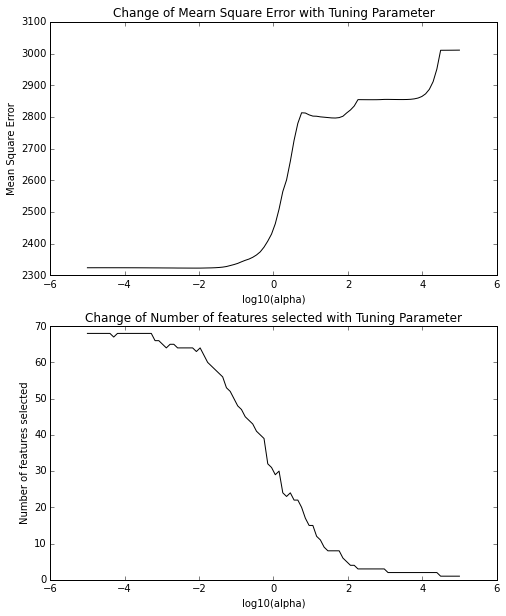

In [42]:
#Plot the results
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(np.log10(np.logspace(-5, 5, num = 100, base =10)), evaluator[:,1], 'k-')
plt.ylabel("Mean Square Error")
plt.xlabel("log10(alpha)")
plt.title("Change of Mearn Square Error with Tuning Parameter")

plt.subplot(212)
plt.plot(np.log10(np.logspace(-5, 5, num = 100, base =10)), num_feature, 'k-')
plt.ylabel("Number of features selected")
plt.xlabel("log10(alpha)")
plt.title("Change of Number of features selected with Tuning Parameter")

plt.show()

0.313073288931
0.0941833153465
(1000L, 5L)
278.81312347


C:\Users\admin\Anaconda2\lib\site-packages\sklearn\linear_model\base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


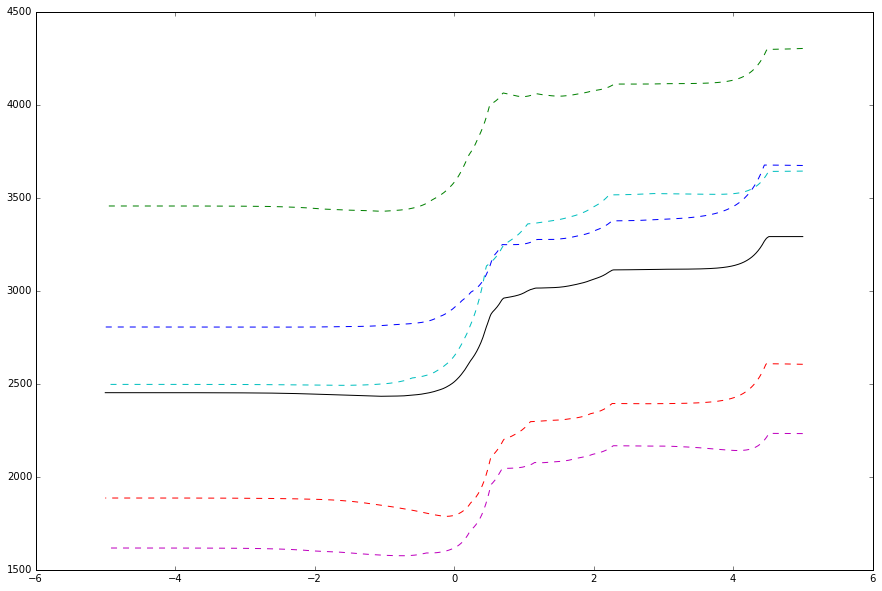

{'alpha': 0.094183315346479515,
 'intercept': 278.81312347035595,
 'r_square': 0.31307328893074404}

In [44]:
lasso_cros(alpha_range, trainPredictor, trainTarget[:,4], testPredictor, testTarget[:,4])

We want to know the selected coefficients for the training data

In [46]:
coefficient_to = lasso_fit(0.094183315346479515, trainPredictor, trainTarget[:,4])

In [47]:
features = find_features(coefficient_to)

[  12.08619048    9.11631579  190.7798889  ...,    6.35667924   33.65894737
  104.811     ]


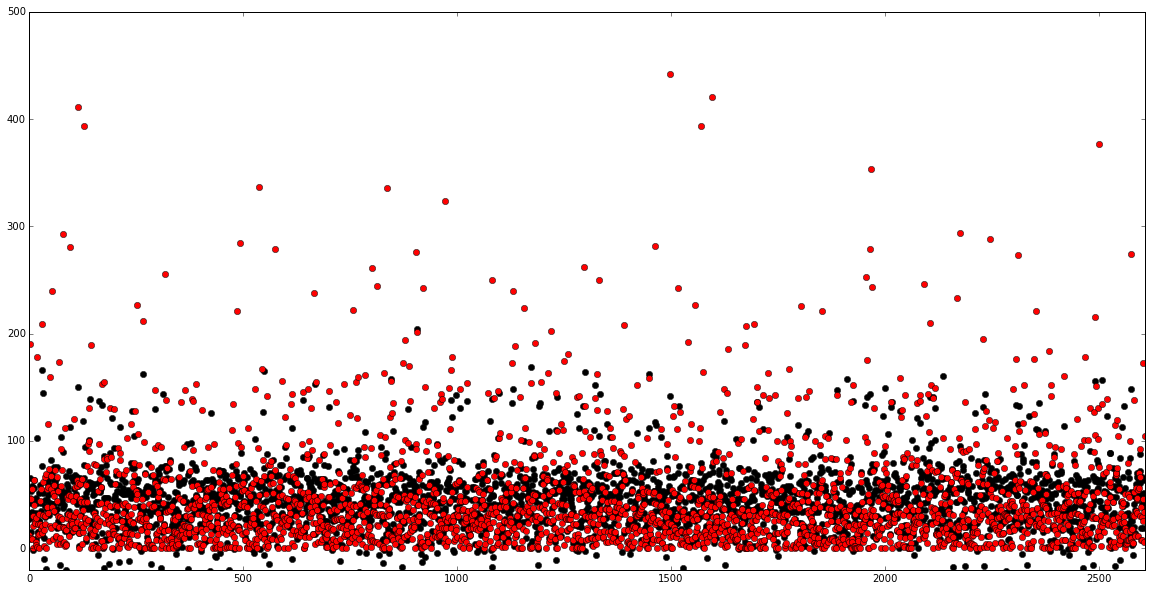

In [48]:
testResults_total = lasso_results(0.17475284000076829, trainPredictor, trainTarget[:,4], testPredictor, testTarget[:,4])
fig2= plt.figure(figsize=(20, 10)) 
plt.plot(list(range(len(testResults_total))), testResults_total, 'ko')
plt.plot(list(range(len(testResults_total))), testTarget[:,4], 'ro')
plt.ylim(-20,500)
plt.xlim(0,len(testResults_total))
print(testTarget[:,4])

Now we try doing the cooling and heating separately

In [49]:
to_feature_index = find_features(coefficient_to)["index"]
code[to_feature_index, 1]

array(['Square footage', 'Year of construction category',
       'Principal building activity', 'Electricity used',
       'Natural gas used', 'Fuel oil/diesel/kerosene used',
       'Bottled gas/LPG/propane used', 'District steam used',
       'District hot water used', 'Percent heated',
       'Boilers inside the building', 'Packaged heating units',
       'Individual space heaters', 'Heat pumps for heating',
       'District steam or hot water piped in', 'Other heating equipment',
       'Percent heated by furnace', 'Percent heated by boilers',
       'Percent heated by packaged heating',
       'Percent heated by indiv space heaters',
       'Percent heated by heat pumps',
       'Percent heated by dist steam/hot water',
       'Percent heated by other heating equip', 'Main heating equipment',
       'Main heating replaced since 1990',
       'Heating reduced during 24 hour period', 'How reduce heating',
       'Percent cooled', 'Residential-type central A/C',
       'Individual ro

In [51]:
def feature_reduc(alpha_input, train_X, train_y, threshold):
    feature_num = len(train_X[0])
    while feature_num > threshold:
        clf = linear_model.Lasso(alpha=alpha_input)
        clf.fit(train_X,train_y)
        feature_index = find_features(clf.coef_)["index"]
        feature_num = len(feature_index)
        alpha_input = alpha_input * 1.2      
    return {'alpha':alpha_input,  'feature_index': feature_index}


In [53]:
# Target 1 most important feature
code[feature_reduc(10, Predictor, Target[:,0],1)["feature_index"],1]

array(['Square footage'], 
      dtype='|S40')

In [54]:
# Target 3 most important feature
code[feature_reduc(10, Predictor, Target[:,0],3)["feature_index"],1]

array(['Square footage', 'Heating degree days (base 65)',
       'Cooling degree days (base 65)'], 
      dtype='|S40')

In [55]:
# Target 5 most important feature
code[feature_reduc(10, Predictor, Target[:,0],5)["feature_index"],1]

array(['Square footage', 'Percent cooled',
       'Percent cooled by packaged A/C', 'Heating degree days (base 65)',
       'Cooling degree days (base 65)'], 
      dtype='|S40')

In [56]:
# Target 10 most important feature
code[feature_reduc(10, Predictor, Target[:,0],10)["feature_index"],1]

array(['Square footage', 'Percent heated', 'Percent heated by boilers',
       'Percent cooled', 'Percent cooled by packaged A/C',
       'Percent cooled by individual room A/C',
       'Percent cooled by central chillers',
       'Heating degree days (base 65)', 'Cooling degree days (base 65)'], 
      dtype='|S40')